
# Clasificación (Adult Income) con **ColumnTransformer** + Pipelines  
### (Logistic Regression & Random Forest)

Version *tipo Titanic*: mezcla de variables **numéricas y categóricas**, con preprocesado usando `ColumnTransformer`:

- Carga del dataset **Adult (Census Income)** desde `sklearn.datasets.fetch_openml`
- Limpieza ligera y preparación del objetivo
- **Split** train/test estratificado
- **Preprocesado**: imputación (num/cat), **OneHotEncoder** (cat) y **StandardScaler** (num)
- **Pipelines** con `LogisticRegression` y `RandomForestClassifier`
- Validación cruzada + tabla comparativa (accuracy, precision, recall, f1, roc_auc)
- Evaluación en test: métricas, matriz de confusión, curvas **ROC** y **Precision-Recall**
- **GridSearchCV** para ambos modelos
- Interpretabilidad: coeficientes (LR) e importancias (RF)


In [3]:

# === Setup ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, classification_report
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams['figure.figsize'] = (7, 5)


## 1) Carga de datos

In [4]:

# Adult / Census Income: target: <=50K / >50K
adult = fetch_openml('adult', version=2, as_frame=True)
df = adult.frame.copy()

# Arreglo del target a binario: 1 si >50K, 0 en caso contrario
df['target'] = (df['class'] == '>50K').astype(int)
df = df.drop(columns=['class'])

# Reemplazar '?' por NaN para tratarlos como faltantes
df = df.replace('?', np.nan)

df.sample(5, random_state=RANDOM_STATE)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
7762,56,Private,33115,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,0,40,United-States,0
23881,25,Private,112847,HS-grad,9,Married-civ-spouse,Transport-moving,Own-child,Other,Male,0,0,40,United-States,0
30507,43,Private,170525,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,14344,0,40,United-States,1
28911,32,Private,186788,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0
19484,39,Private,277886,Bachelors,13,Married-civ-spouse,Sales,Wife,White,Female,0,0,30,United-States,0


### Info rápida

In [5]:

X = df.drop(columns=['target'])
y = df['target']

display(pd.DataFrame({
    'n_rows': [len(df)],
    'n_features': [X.shape[1]],
    'pos_ratio_%': [100 * y.mean()]
}))

display(X.dtypes.value_counts().rename('count').to_frame())
display(X.isna().mean().sort_values(ascending=False).head(10).rename('missing_ratio'))


,n_rows,n_features,pos_ratio_%
0,48842,14,23.928177


,count
int64,6
category,1
category,1
category,1
category,1
category,1
category,1
category,1
category,1


occupation        0.057512
workclass         0.057307
native-country    0.017546
education         0.000000
fnlwgt            0.000000
age               0.000000
marital-status    0.000000
education-num     0.000000
race              0.000000
relationship      0.000000
Name: missing_ratio, dtype: float64

## 2) Train/Test split (estratificado)

In [6]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((39073, 14),
 (9769, 14),
 np.float64(0.23927008420136667),
 np.float64(0.23932848807452145))

## 3) Preprocesado con **ColumnTransformer**

In [7]:

# Selección automática de columnas numéricas y categóricas
num_cols = selector(dtype_include=np.number)(X_train)
cat_cols = selector(dtype_include=object)(X_train)

num_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess = ColumnTransformer([
    ('num', num_tf, num_cols),
    ('cat', cat_tf, cat_cols)
])

num_cols[:5], cat_cols[:5], len(num_cols), len(cat_cols)


(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss'], [], 6, 0)

## 4) Pipelines base (LR & RF)

In [8]:

pipe_lr = Pipeline([
    ('preprocess', preprocess),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, n_jobs=None))
])

pipe_rf = Pipeline([
    ('preprocess', preprocess),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])

pipe_lr, pipe_rf


(Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['age', 'fnlwgt',
                                                    'education-num',
                                                    'capital-gain',
                                                    'capital-loss',
                                                    'hours-per-week']),
                                                  ('cat',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImpu

## 5) Validación cruzada y comparativa de modelos

In [9]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

cv_lr = cross_validate(pipe_lr, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
cv_rf = cross_validate(pipe_rf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

def summarize_cv(cvres, label):
    return pd.Series({
        "model": label,
        **{f"{m}_mean": np.mean(cvres[f'test_{m}']) for m in scoring.keys()},
        **{f"{m}_std": np.std(cvres[f'test_{m}']) for m in scoring.keys()},
    })

summary = pd.concat([summarize_cv(cv_lr, "LogisticRegression"), summarize_cv(cv_rf, "RandomForest")], axis=1).T
summary.sort_values("roc_auc_mean", ascending=False).reset_index(drop=True)


,model,accuracy_mean,precision_mean,recall_mean,f1_mean,roc_auc_mean,accuracy_std,precision_std,recall_std,f1_std,roc_auc_std
0,LogisticRegression,0.813247,0.702161,0.381859,0.494567,0.828643,0.005228,0.024033,0.010627,0.012788,0.006537
1,RandomForest,0.80713,0.618511,0.506256,0.556716,0.82439,0.004028,0.010773,0.01219,0.010184,0.005979


## 6) Entrenamiento y evaluación en test

In [17]:

pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

y_pred_lr = pipe_lr.predict(X_test)
y_proba_lr = pipe_lr.predict_proba(X_test)[:, 1]

y_pred_rf = pipe_rf.predict(X_test)
y_proba_rf = pipe_rf.predict_proba(X_test)[:, 1]

def metrics_row(y_true, y_pred, y_proba, label):
    return pd.Series({
        "model": label,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_proba),
    })

test_metrics = pd.concat([
    metrics_row(y_test, y_pred_lr, y_proba_lr, "LogisticRegression"),
    metrics_row(y_test, y_pred_rf, y_proba_rf, "RandomForest")
], axis=1).T

test_metrics


,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,0.819941,0.734413,0.387938,0.507697,0.832526
1,RandomForest,0.813389,0.63675,0.512831,0.568112,0.824613


### Matrices de confusión

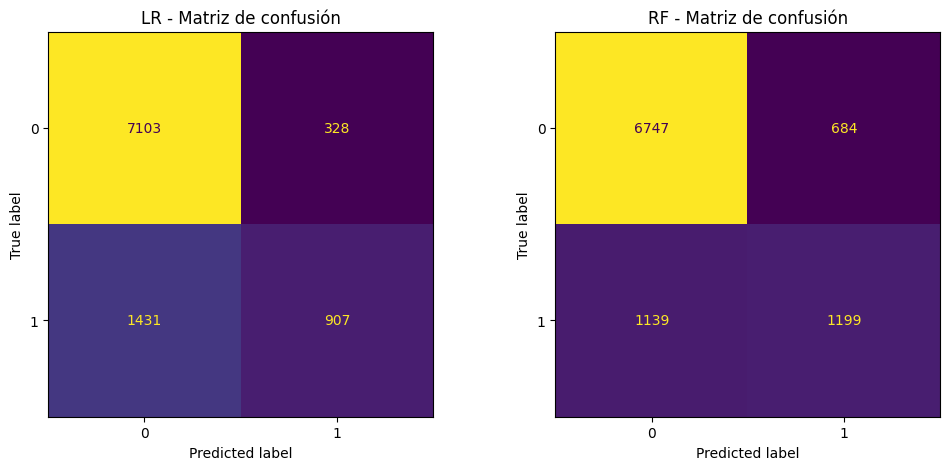

In [11]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_lr)).plot(ax=axes[0], colorbar=False)
axes[0].set_title("LR - Matriz de confusión")
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf)).plot(ax=axes[1], colorbar=False)
axes[1].set_title("RF - Matriz de confusión")
plt.show()


### Curvas ROC y Precision-Recall

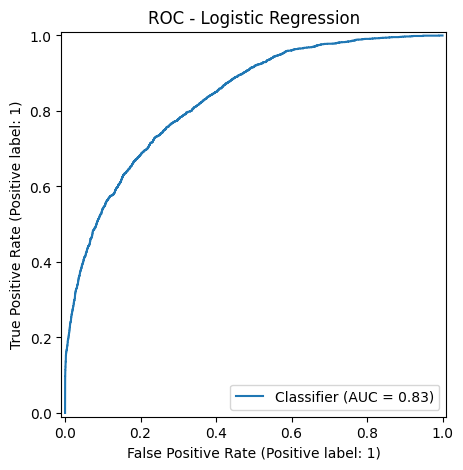

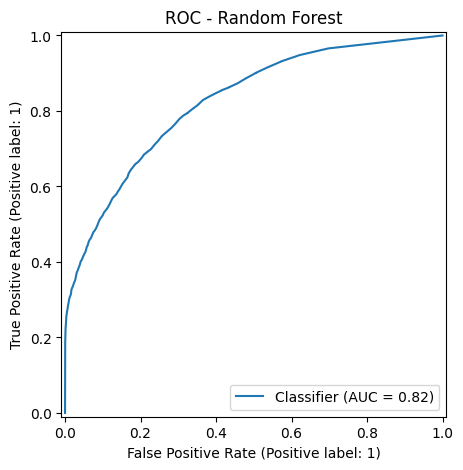

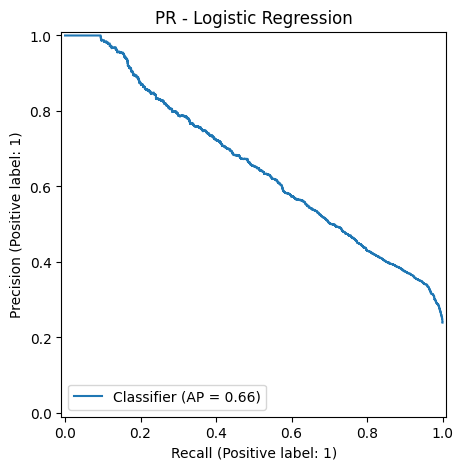

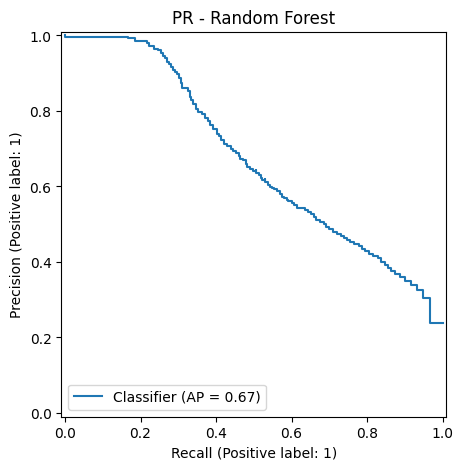

In [12]:

RocCurveDisplay.from_predictions(y_test, y_proba_lr)
plt.title("ROC - Logistic Regression")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.title("ROC - Random Forest")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba_lr)
plt.title("PR - Logistic Regression")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba_rf)
plt.title("PR - Random Forest")
plt.show()


## 7) Interpretabilidad

In [18]:

# Recuperar nombres de columnas tras el preprocesado para el pipeline LR
pre = pipe_lr.named_steps['preprocess']
cat_features = pre.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(cat_cols)
num_features = np.array(num_cols)
feature_names = np.concatenate([num_features, cat_features])

lr = pipe_lr.named_steps['clf']
coefs = pd.DataFrame({
    'feature': feature_names,
    'coef': lr.coef_.flatten()
}).sort_values('coef', key=np.abs, ascending=False)

coefs.head(15)


NotFittedError: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:

# Importancias del RF (ojo: se refieren al espacio transformado con OHE)
rf = pipe_rf.named_steps['clf']
importances = pd.DataFrame({
    'feature': feature_names,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

importances.head(15)


NameError: name 'feature_names' is not defined

## 8) Búsqueda de hiperparámetros (GridSearchCV)

In [ ]:

param_grid_lr = {
    "clf__C": [0.01, 0.1, 1.0, 10.0],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs", "liblinear"]
}
grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=cv, scoring="roc_auc", n_jobs=-1)
grid_lr.fit(X_train, y_train)

print("Mejor LR:", grid_lr.best_params_, "AUC:", grid_lr.best_score_)


In [ ]:

param_grid_rf = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 6, 10, 14],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2"]
}
grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=cv, scoring="roc_auc", n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Mejor RF:", grid_rf.best_params_, "AUC:", grid_rf.best_score_)


### Evaluación en test con los mejores modelos

In [ ]:

best_lr = grid_lr.best_estimator_
best_rf = grid_rf.best_estimator_

for label, model in [("Best LR", best_lr), ("Best RF", best_rf)]:
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"\n=== {label} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))


## 9) Exportar modelos entrenados (opcional)

In [ ]:

import joblib

joblib.dump(best_lr, "adult_best_lr.joblib")
joblib.dump(best_rf, "adult_best_rf.joblib")

print("Guardados: adult_best_lr.joblib, adult_best_rf.joblib")



---

### Notas
- Este notebook replica el patrón de **Titanic** (num + cat) cambiando solo el dataset.
- Si prefieres otro dataset con mezcla num/cat (p. ej. *Heart Disease*), te preparo otra variante.
- Ideas extra: *calibration curves*, **class weights** (la clase positiva es menos frecuente), *learning curves* y *permutation importance*.
